In [7]:
import re
import time
import xarray as xr
import pandas as pd
import os
import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import netCDF4 as nc
from IPython import display

import netrc
netrc = netrc.netrc()
remoteHostName = "ooinet.oceanobservatories.org"
info = netrc.authenticators(remoteHostName)
username = info[0]
token = info[2]

In [8]:
subsite = 'RS01SBPS'
node = 'SF01A'
sensor = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'
beginDT = '2016-10-01T01:01:01.000Z'
endDT = '2016-12-01T01:01:01.000Z'

In [9]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [10]:
data['allURLs'][1]

u'https://opendap.oceanobservatories.org/async_results/friedrich.knuth@rutgers.edu/20180221T145723-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample'

In [11]:
data['allURLs'][0]

u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich.knuth@rutgers.edu/20180221T145723-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'

In [12]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 1.39 s, sys: 109 ms, total: 1.5 s
Wall time: 1min 31s


In [13]:
url = data['allURLs'][0]
# url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich.knuth@rutgers.edu/20180221T052204-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [14]:
datasets

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/friedrich.knuth@rutgers.edu/20180221T145723-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20161001T010101.146411-20161201T010100.795608.nc']

In [15]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:                     (time: 5266340)
Coordinates:
    obs                         (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * time                        (time) datetime64[ns] 2016-10-01T01:01:01.146411008 ...
    lat                         (time) float64 dask.array<shape=(5266340,), chunksize=(5266340,)>
    lon                         (time) float64 dask.array<shape=(5266340,), chunksize=(5266340,)>
Data variables:
    deployment                  (time) int32 dask.array<shape=(5266340,), chunksize=(5266340,)>
    id                          (time) |S64 dask.array<shape=(5266340,), chunksize=(5266340,)>
    conductivity                (time) float64 dask.array<shape=(5266340,), chunksize=(5266340,)>
    driver_timestamp            (time) datetime64[ns] dask.array<shape=(5266340,), chunksize=(5266340,)>
    ext_volt0                   (time) float64 dask.array<shape=(5266340,), chunksize=(5266340,)>
    ingestion_timestamp         (time) datetime64

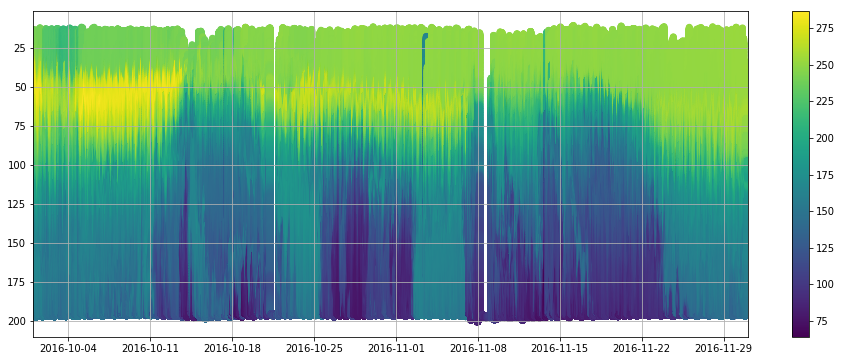

In [20]:
x = ds['time'].values
y = ds['seawater_pressure'].values
z = ds['corrected_dissolved_oxygen'].values
fig, ax = plt.subplots()
fig.set_size_inches(16, 6);
ax.invert_yaxis()
ax.grid()
ax.set_xlim(x[0],x[-1])
sc = plt.scatter(x, y, c=z)
cb = fig.colorbar(sc, ax=ax)
cb.update_ticks()
cb.formatter.set_useOffset(False)
plt.show()